# VIF Critic Model Comparison: MLP vs TCN vs BNN

This notebook provides an **apples-to-apples comparison** between three critic architectures by training and evaluating all on the **exact same dataset**.

**Models:**
1. **CriticMLP** — Baseline 2-layer MLP with MC Dropout
2. **CriticTCN** — Temporal Convolutional Network with MC Dropout
3. **CriticBNN** — Bayesian Neural Network with variational inference

**Contents:**
1. Setup & Data Loading
2. Model Definitions
3. Training Infrastructure
4. Train MLP
5. Train TCN
6. Train BNN
7. Side-by-Side Evaluation
8. Analysis & Conclusions

In [1]:
# Setup
import os
import sys
from pathlib import Path

# Change to project root
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    os.chdir(notebook_dir.parent)
sys.path.insert(0, ".")

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device selection
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Using device: {device}")
print(f"Random seed: {SEED}")

Working directory: /Users/desmondchoy/Projects/twinkl
Using device: mps
Random seed: 42


## 1. Data Loading

Load the current dataset and create identical train/val/test splits for both models.

In [2]:
from src.vif.dataset import load_all_data, split_by_persona, VIFDataset
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder
from src.models.judge import SCHWARTZ_VALUE_ORDER

# Load raw data
labels_df, entries_df = load_all_data()

print(f"Labels: {labels_df.shape}")
print(f"Entries: {entries_df.shape}")
print(f"Unique personas: {labels_df.select('persona_id').n_unique()}")

# Split by persona (same seed = same split for both models)
train_df, val_df, test_df = split_by_persona(labels_df, entries_df, seed=SEED)

print(f"\nData Split:")
print(
    f"  Train: {len(train_df)} entries ({train_df.select('persona_id').n_unique()} personas)"
)
print(
    f"  Val:   {len(val_df)} entries ({val_df.select('persona_id').n_unique()} personas)"
)
print(
    f"  Test:  {len(test_df)} entries ({test_df.select('persona_id').n_unique()} personas)"
)

Labels: (740, 15)
Entries: (729, 8)
Unique personas: 102

Data Split:
  Train: 484 entries (70 personas)
  Val:   126 entries (15 personas)
  Test:  119 entries (16 personas)


In [3]:
# Create shared encoder (same for both models)
WINDOW_SIZE = 3
EMA_ALPHA = 0.3
BATCH_SIZE = 16

text_encoder = SBERTEncoder("all-MiniLM-L6-v2")
state_encoder = StateEncoder(text_encoder, window_size=WINDOW_SIZE, ema_alpha=EMA_ALPHA)

print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")
print(f"State dim: {state_encoder.state_dim}")
print(f"Window size: {WINDOW_SIZE}")

/Users/desmondchoy/Projects/twinkl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoder: all-MiniLM-L6-v2
Embedding dim: 384
State dim: 1174
Window size: 3


In [4]:
# Create datasets (embeddings cached and shared)
print("Creating datasets (this caches embeddings)...")
train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Creating datasets (this caches embeddings)...


Batches: 100%|██████████| 4/4 [00:00<00:00, 109.97it/s]

Train batches: 31
Val batches: 8
Test batches: 8


## 2. Model Definitions

Define all three architectures. CriticMLP and CriticBNN are imported from src/vif, CriticTCN is defined here.

In [5]:
from src.vif.critic import CriticMLP

# TCN requires pytorch-tcn package
try:
    from pytorch_tcn import TCN

    TCN_AVAILABLE = True
except ImportError:
    print("WARNING: pytorch-tcn not installed. Run: uv add pytorch-tcn")
    TCN_AVAILABLE = False

# BNN requires bayesian-torch package
try:
    from src.vif.critic_bnn import CriticBNN, get_kl_loss

    BNN_AVAILABLE = True
except ImportError:
    print("WARNING: bayesian-torch not installed. Run: uv add bayesian-torch")
    BNN_AVAILABLE = False


class CriticTCN(nn.Module):
    """TCN critic over a short embedding window.

    Processes text embeddings through temporal convolutions, then concatenates
    non-text features and predicts alignment scores.
    """

    def __init__(
        self,
        *,
        window_size: int,
        embedding_dim: int,
        num_values: int = 10,
        tcn_num_channels: list[int] = [64, 64, 64],
        tcn_kernel_size: int = 3,
        tcn_dropout: float = 0.1,
        head_hidden_dim: int = 128,
        head_dropout: float = 0.2,
        output_dim: int = 10,
    ):
        super().__init__()

        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.num_values = num_values
        self.output_dim = output_dim

        # Non-text dims: time_gaps + history + profile
        self.nontext_dim = (window_size - 1) + num_values + num_values

        self.tcn = TCN(
            num_inputs=embedding_dim,
            num_channels=tcn_num_channels,
            kernel_size=tcn_kernel_size,
            dropout=tcn_dropout,
            causal=True,
            use_norm="weight_norm",
            activation="relu",
            input_shape="NCL",
        )

        tcn_out_dim = tcn_num_channels[-1]
        head_in_dim = tcn_out_dim + self.nontext_dim

        self.head = nn.Sequential(
            nn.Linear(head_in_dim, head_hidden_dim),
            nn.LayerNorm(head_hidden_dim),
            nn.GELU(),
            nn.Dropout(head_dropout),
        )
        self.out = nn.Linear(head_hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def _split_state(self, x: torch.Tensor):
        text_flat_dim = self.window_size * self.embedding_dim
        text_flat = x[:, :text_flat_dim]
        nontext = x[:, text_flat_dim : text_flat_dim + self.nontext_dim]
        return text_flat, nontext

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        text_flat, nontext = self._split_state(x)

        # Reshape: (N, window*emb) -> (N, emb, window) for TCN
        text_seq = text_flat.view(-1, self.window_size, self.embedding_dim).permute(
            0, 2, 1
        )

        # TCN output: (N, C_out, L) -> take last timestep
        tcn_out = self.tcn(text_seq)
        h = tcn_out[:, :, -1]

        # Concat non-text features and predict
        features = torch.cat([h, nontext], dim=1)
        h2 = self.head(features)
        return self.tanh(self.out(h2))

    def enable_dropout(self):
        """Enable dropout for MC Dropout inference."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

    def predict_with_uncertainty(self, x: torch.Tensor, n_samples: int = 50):
        """MC Dropout uncertainty estimation."""
        self.enable_dropout()
        samples = []
        with torch.no_grad():
            for _ in range(n_samples):
                samples.append(self.forward(x))
        samples = torch.stack(samples, dim=0)
        return samples.mean(dim=0), samples.std(dim=0)


print("Model classes defined.")
print(f"TCN available: {TCN_AVAILABLE}")
print(f"BNN available: {BNN_AVAILABLE}")

Model classes defined.
TCN available: True
BNN available: True


## 3. Training Infrastructure

Shared training function to ensure identical training procedure for both models.

In [6]:
def train_model(
    model,
    train_loader,
    val_loader,
    *,
    n_epochs: int = 100,
    lr: float = 0.001,
    weight_decay: float = 0.01,
    early_stop_patience: int = 20,
    device: str = "cpu",
    verbose: bool = True,
    use_kl_loss: bool = False,  # For BNN training
):
    """Train a model with early stopping.

    Args:
        use_kl_loss: If True, adds KL divergence loss for BNN training.

    Returns:
        dict with best_model_state, best_val_loss, and history
    """
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
    )

    history = {"train_loss": [], "val_loss": [], "lr": []}
    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0

    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            pred = model(batch_x)
            mse_loss = criterion(pred, batch_y)

            # Add KL divergence for BNN
            if use_kl_loss:
                kl_loss = get_kl_loss(model)
                loss = mse_loss + kl_loss / batch_x.size(0)
            else:
                loss = mse_loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validate (MSE only, no KL)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                pred = model(batch_x)
                val_loss += criterion(pred, batch_y).item()
        val_loss /= len(val_loader)

        # Update scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]["lr"]

        # Record history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(current_lr)

        # Early stopping check
        if val_loss < best_val_loss - 0.001:
            best_val_loss = val_loss
            best_model_state = {
                k: v.cpu().clone() for k, v in model.state_dict().items()
            }
            patience_counter = 0
            if verbose:
                print(
                    f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f} [BEST]"
                )
        else:
            patience_counter += 1
            if verbose and epoch % 10 == 0:
                print(
                    f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f}"
                )

        if patience_counter >= early_stop_patience:
            if verbose:
                print(f"Early stopping at epoch {epoch + 1}")
            break

    return {
        "best_model_state": best_model_state,
        "best_val_loss": best_val_loss,
        "history": history,
        "epochs_trained": epoch + 1,
    }


print("Training function defined.")

Training function defined.


## 4. Train MLP

In [7]:
# MLP hyperparameters (from existing notebook)
MLP_HIDDEN_DIM = 256
MLP_DROPOUT = 0.2

mlp_model = CriticMLP(
    input_dim=state_encoder.state_dim,
    hidden_dim=MLP_HIDDEN_DIM,
    dropout=MLP_DROPOUT,
)

mlp_params = sum(p.numel() for p in mlp_model.parameters())
print(f"MLP parameters: {mlp_params:,}")
print(f"\nTraining MLP...")

mlp_result = train_model(
    mlp_model,
    train_loader,
    val_loader,
    device=device,
)

print(f"\nMLP best val loss: {mlp_result['best_val_loss']:.4f}")
print(f"MLP epochs trained: {mlp_result['epochs_trained']}")

MLP parameters: 370,186

Training MLP...
Epoch   1: train=0.3334, val=0.3029, lr=0.001000 [BEST]
Epoch   2: train=0.2891, val=0.2900, lr=0.001000 [BEST]
Epoch   3: train=0.2628, val=0.2719, lr=0.001000 [BEST]
Epoch   4: train=0.2613, val=0.2687, lr=0.001000 [BEST]
Epoch   5: train=0.2487, val=0.2677, lr=0.001000 [BEST]
Epoch   6: train=0.2473, val=0.2651, lr=0.001000 [BEST]
Epoch   8: train=0.2428, val=0.2591, lr=0.001000 [BEST]
Epoch  11: train=0.2358, val=0.2606, lr=0.001000
Epoch  21: train=0.2250, val=0.2586, lr=0.001000
Early stopping at epoch 28

MLP best val loss: 0.2591
MLP epochs trained: 28


## 5. Train TCN

In [8]:
if not TCN_AVAILABLE:
    print("Skipping TCN training - pytorch-tcn not installed")
    tcn_result = None
else:
    # TCN hyperparameters
    # TODO(human): Choose TCN channel width to test capacity hypothesis
    TCN_NUM_CHANNELS = [64, 64, 64]  # Original from PR
    # TCN_NUM_CHANNELS = [256, 256]  # Match MLP capacity
    TCN_KERNEL_SIZE = 3
    TCN_DROPOUT = 0.1
    TCN_HEAD_HIDDEN = 128
    TCN_HEAD_DROPOUT = 0.2

    tcn_model = CriticTCN(
        window_size=WINDOW_SIZE,
        embedding_dim=text_encoder.embedding_dim,
        tcn_num_channels=TCN_NUM_CHANNELS,
        tcn_kernel_size=TCN_KERNEL_SIZE,
        tcn_dropout=TCN_DROPOUT,
        head_hidden_dim=TCN_HEAD_HIDDEN,
        head_dropout=TCN_HEAD_DROPOUT,
    )

    tcn_params = sum(p.numel() for p in tcn_model.parameters())
    print(f"TCN parameters: {tcn_params:,}")
    print(f"TCN channels: {TCN_NUM_CHANNELS}")
    print(f"\nTraining TCN...")

    tcn_result = train_model(
        tcn_model,
        train_loader,
        val_loader,
        device=device,
    )

    print(f"\nTCN best val loss: {tcn_result['best_val_loss']:.4f}")
    print(f"TCN epochs trained: {tcn_result['epochs_trained']}")

TCN parameters: 173,258
TCN channels: [64, 64, 64]

Training TCN...
Epoch   1: train=0.3031, val=0.2703, lr=0.001000 [BEST]
Epoch   2: train=0.2583, val=0.2621, lr=0.001000 [BEST]
Epoch   3: train=0.2438, val=0.2579, lr=0.001000 [BEST]
Epoch   5: train=0.2380, val=0.2557, lr=0.001000 [BEST]
Epoch  11: train=0.2232, val=0.2593, lr=0.001000
Epoch  21: train=0.2078, val=0.2704, lr=0.000500
Early stopping at epoch 25

TCN best val loss: 0.2557
TCN epochs trained: 25


## 6. Train BNN

In [9]:
if not BNN_AVAILABLE:
    print("Skipping BNN training - bayesian-torch not installed")
    bnn_result = None
else:
    # BNN hyperparameters (match MLP capacity)
    BNN_HIDDEN_DIM = 256

    bnn_model = CriticBNN(
        input_dim=state_encoder.state_dim,
        hidden_dim=BNN_HIDDEN_DIM,
    )

    bnn_params = sum(p.numel() for p in bnn_model.parameters())
    print(f"BNN parameters: {bnn_params:,}")
    print(f"\nTraining BNN (with KL loss)...")

    bnn_result = train_model(
        bnn_model,
        train_loader,
        val_loader,
        device=device,
        use_kl_loss=True,  # Key difference: adds KL divergence
    )

    print(f"\nBNN best val loss: {bnn_result['best_val_loss']:.4f}")
    print(f"BNN epochs trained: {bnn_result['epochs_trained']}")

BNN parameters: 739,348

Training BNN (with KL loss)...
Epoch   1: train=1.5905, val=0.4567, lr=0.001000 [BEST]
Epoch   3: train=1.4178, val=0.3944, lr=0.001000 [BEST]
Epoch   4: train=1.3775, val=0.3900, lr=0.001000 [BEST]
Epoch   5: train=1.3354, val=0.3653, lr=0.001000 [BEST]
Epoch   6: train=1.3279, val=0.3432, lr=0.001000 [BEST]
Epoch   8: train=1.3060, val=0.3322, lr=0.001000 [BEST]
Epoch  11: train=1.2667, val=0.3128, lr=0.001000 [BEST]
Epoch  12: train=1.2562, val=0.2992, lr=0.001000 [BEST]
Epoch  14: train=1.2452, val=0.2924, lr=0.001000 [BEST]
Epoch  16: train=1.2379, val=0.2882, lr=0.001000 [BEST]
Epoch  17: train=1.2240, val=0.2824, lr=0.001000 [BEST]
Epoch  21: train=1.1993, val=0.3077, lr=0.001000
Epoch  22: train=1.1932, val=0.2788, lr=0.001000 [BEST]
Epoch  31: train=1.1374, val=0.2764, lr=0.001000 [BEST]
Epoch  41: train=1.0920, val=0.2926, lr=0.001000
Epoch  49: train=1.0677, val=0.2724, lr=0.000500 [BEST]
Epoch  51: train=1.0573, val=0.2870, lr=0.000500
Epoch  61: tr

## 7. Side-by-Side Evaluation

In [10]:
from src.vif.eval import evaluate_with_uncertainty, format_results_table

N_MC_SAMPLES = 50

# Evaluate MLP
mlp_model.load_state_dict(mlp_result["best_model_state"])
mlp_model.to(device)
print("Evaluating MLP on test set...")
mlp_results = evaluate_with_uncertainty(
    mlp_model, test_loader, n_mc_samples=N_MC_SAMPLES, device=device
)

# Evaluate TCN
if tcn_result is not None:
    tcn_model.load_state_dict(tcn_result["best_model_state"])
    tcn_model.to(device)
    print("Evaluating TCN on test set...")
    tcn_results = evaluate_with_uncertainty(
        tcn_model, test_loader, n_mc_samples=N_MC_SAMPLES, device=device
    )
else:
    tcn_results = None

# Evaluate BNN
if bnn_result is not None:
    bnn_model.load_state_dict(bnn_result["best_model_state"])
    bnn_model.to(device)
    print("Evaluating BNN on test set...")
    bnn_results = evaluate_with_uncertainty(
        bnn_model, test_loader, n_mc_samples=N_MC_SAMPLES, device=device
    )
else:
    bnn_results = None

Evaluating MLP on test set...
Evaluating TCN on test set...
Evaluating BNN on test set...


In [11]:
print("=" * 70)
print("MLP RESULTS")
print("=" * 70)
print(format_results_table(mlp_results))

MLP RESULTS
Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3096      0.579     53.78%
stimulation              0.1333      0.541     87.39%
hedonism                 0.2710      0.461     65.55%
achievement              0.2619      0.346     69.75%
power                    0.1541      0.186     84.87%
security                 0.2720      0.426     66.39%
conformity               0.2555      0.516     73.11%
tradition                0.2243      0.411     70.59%
benevolence              0.3231      0.426     62.18%
universalism             0.1175      0.558     78.99%
----------------------------------------------------------------------
MEAN                     0.2322      0.445     71.26%

Calibration:
  Error-uncertainty correlation: 0.012
  Mean uncertainty: 0.0775


In [12]:
if tcn_results is not None:
    print("=" * 70)
    print("TCN RESULTS")
    print("=" * 70)
    print(format_results_table(tcn_results))
else:
    print("TCN results not available (pytorch-tcn not installed)")

TCN RESULTS
Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3167      0.578     53.78%
stimulation              0.1304      0.504     87.39%
hedonism                 0.2668      0.426     70.59%
achievement              0.2723      0.271     70.59%
power                    0.1618      0.096     84.87%
security                 0.2874      0.357     68.07%
conformity               0.2486      0.529     72.27%
tradition                0.2206      0.442     71.43%
benevolence              0.3462      0.391     57.14%
universalism             0.1116      0.551     86.55%
----------------------------------------------------------------------
MEAN                     0.2363      0.415     72.27%

Calibration:
  Error-uncertainty correlation: -0.106
  Mean uncertainty: 0.0951


In [13]:
if bnn_results is not None:
    print("=" * 70)
    print("BNN RESULTS")
    print("=" * 70)
    print(format_results_table(bnn_results))
else:
    print("BNN results not available (bayesian-torch not installed)")

BNN RESULTS
Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3097      0.563     57.98%
stimulation              0.1291      0.534     87.39%
hedonism                 0.2559      0.488     74.79%
achievement              0.2592      0.365     71.43%
power                    0.1522      0.201     84.87%
security                 0.2748      0.344     69.75%
conformity               0.2474      0.478     73.95%
tradition                0.2321      0.394     68.91%
benevolence              0.3274      0.404     62.18%
universalism             0.1103      0.518     87.39%
----------------------------------------------------------------------
MEAN                     0.2298      0.429     73.87%

Calibration:
  Error-uncertainty correlation: -0.247
  Mean uncertainty: 0.1642


In [14]:
# Side-by-side comparison table
print("\n" + "=" * 90)
print("SIDE-BY-SIDE COMPARISON")
print("=" * 90)

print(f"{'Metric':<30} {'MLP':>15} {'TCN':>15} {'BNN':>15} {'Winner':>12}")
print("-" * 90)


def get_winner(*values_and_names, higher_is_better=True):
    """Determine winner from (value, name) pairs, handling None values."""
    valid = [(v, n) for v, n in values_and_names if v is not None]
    if not valid:
        return "N/A"
    if higher_is_better:
        return max(valid, key=lambda x: x[0])[1]
    else:
        return min(valid, key=lambda x: x[0])[1]


metrics = [
    (
        "Parameters",
        f"{mlp_params:,}",
        f"{tcn_params:,}" if tcn_result else "N/A",
        f"{bnn_params:,}" if bnn_result else "N/A",
        get_winner(
            (mlp_params, "MLP"),
            (tcn_params if tcn_result else None, "TCN"),
            (bnn_params if bnn_result else None, "BNN"),
            higher_is_better=False,
        ),
    ),
    (
        "Best Val Loss",
        f"{mlp_result['best_val_loss']:.4f}",
        f"{tcn_result['best_val_loss']:.4f}" if tcn_result else "N/A",
        f"{bnn_result['best_val_loss']:.4f}" if bnn_result else "N/A",
        get_winner(
            (mlp_result["best_val_loss"], "MLP"),
            (tcn_result["best_val_loss"] if tcn_result else None, "TCN"),
            (bnn_result["best_val_loss"] if bnn_result else None, "BNN"),
            higher_is_better=False,
        ),
    ),
    (
        "Test MSE",
        f"{mlp_results['mse_mean']:.4f}",
        f"{tcn_results['mse_mean']:.4f}" if tcn_results else "N/A",
        f"{bnn_results['mse_mean']:.4f}" if bnn_results else "N/A",
        get_winner(
            (mlp_results["mse_mean"], "MLP"),
            (tcn_results["mse_mean"] if tcn_results else None, "TCN"),
            (bnn_results["mse_mean"] if bnn_results else None, "BNN"),
            higher_is_better=False,
        ),
    ),
    (
        "Test Spearman",
        f"{mlp_results['spearman_mean']:.4f}",
        f"{tcn_results['spearman_mean']:.4f}" if tcn_results else "N/A",
        f"{bnn_results['spearman_mean']:.4f}" if bnn_results else "N/A",
        get_winner(
            (mlp_results["spearman_mean"], "MLP"),
            (tcn_results["spearman_mean"] if tcn_results else None, "TCN"),
            (bnn_results["spearman_mean"] if bnn_results else None, "BNN"),
            higher_is_better=True,
        ),
    ),
    (
        "Test Accuracy",
        f"{mlp_results['accuracy_mean']:.2%}",
        f"{tcn_results['accuracy_mean']:.2%}" if tcn_results else "N/A",
        f"{bnn_results['accuracy_mean']:.2%}" if bnn_results else "N/A",
        get_winner(
            (mlp_results["accuracy_mean"], "MLP"),
            (tcn_results["accuracy_mean"] if tcn_results else None, "TCN"),
            (bnn_results["accuracy_mean"] if bnn_results else None, "BNN"),
            higher_is_better=True,
        ),
    ),
    (
        "Error-Uncertainty Corr",
        f"{mlp_results['calibration']['error_uncertainty_correlation']:.3f}",
        f"{tcn_results['calibration']['error_uncertainty_correlation']:.3f}"
        if tcn_results
        else "N/A",
        f"{bnn_results['calibration']['error_uncertainty_correlation']:.3f}"
        if bnn_results
        else "N/A",
        get_winner(
            (mlp_results["calibration"]["error_uncertainty_correlation"], "MLP"),
            (
                tcn_results["calibration"]["error_uncertainty_correlation"]
                if tcn_results
                else None,
                "TCN",
            ),
            (
                bnn_results["calibration"]["error_uncertainty_correlation"]
                if bnn_results
                else None,
                "BNN",
            ),
            higher_is_better=True,
        ),
    ),
]

for metric, mlp_val, tcn_val, bnn_val, winner in metrics:
    print(f"{metric:<30} {mlp_val:>15} {tcn_val:>15} {bnn_val:>15} {winner:>12}")

print("=" * 90)


SIDE-BY-SIDE COMPARISON
Metric                                     MLP             TCN             BNN       Winner
------------------------------------------------------------------------------------------
Parameters                             370,186         173,258         739,348          TCN
Best Val Loss                           0.2591          0.2557          0.2724          TCN
Test MSE                                0.2322          0.2363          0.2298          BNN
Test Spearman                           0.4450          0.4146          0.4289          MLP
Test Accuracy                           71.26%          72.27%          73.87%          BNN
Error-Uncertainty Corr                   0.012          -0.106          -0.247          MLP


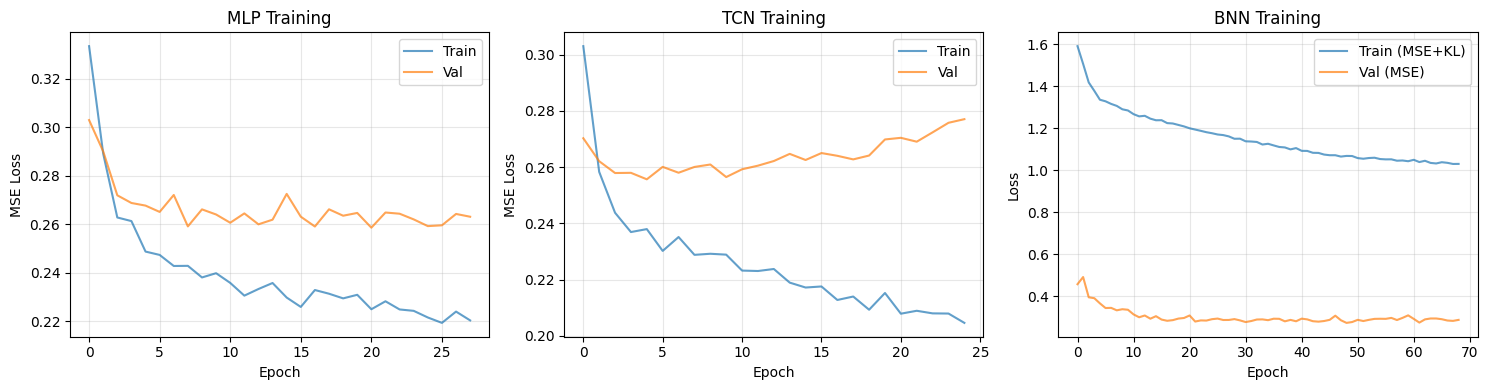

In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# MLP curves
axes[0].plot(mlp_result["history"]["train_loss"], label="Train", alpha=0.7)
axes[0].plot(mlp_result["history"]["val_loss"], label="Val", alpha=0.7)
axes[0].set_title("MLP Training")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# TCN curves
if tcn_result:
    axes[1].plot(tcn_result["history"]["train_loss"], label="Train", alpha=0.7)
    axes[1].plot(tcn_result["history"]["val_loss"], label="Val", alpha=0.7)
    axes[1].set_title("TCN Training")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("MSE Loss")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "TCN not available", ha="center", va="center")
    axes[1].set_title("TCN Training")

# BNN curves
if bnn_result:
    axes[2].plot(bnn_result["history"]["train_loss"], label="Train (MSE+KL)", alpha=0.7)
    axes[2].plot(bnn_result["history"]["val_loss"], label="Val (MSE)", alpha=0.7)
    axes[2].set_title("BNN Training")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, "BNN not available", ha="center", va="center")
    axes[2].set_title("BNN Training")

plt.tight_layout()
plt.show()

## 8. Diagnostic Analysis: Understanding Calibration

Let's diagnose why BNN has negative error-uncertainty correlation.

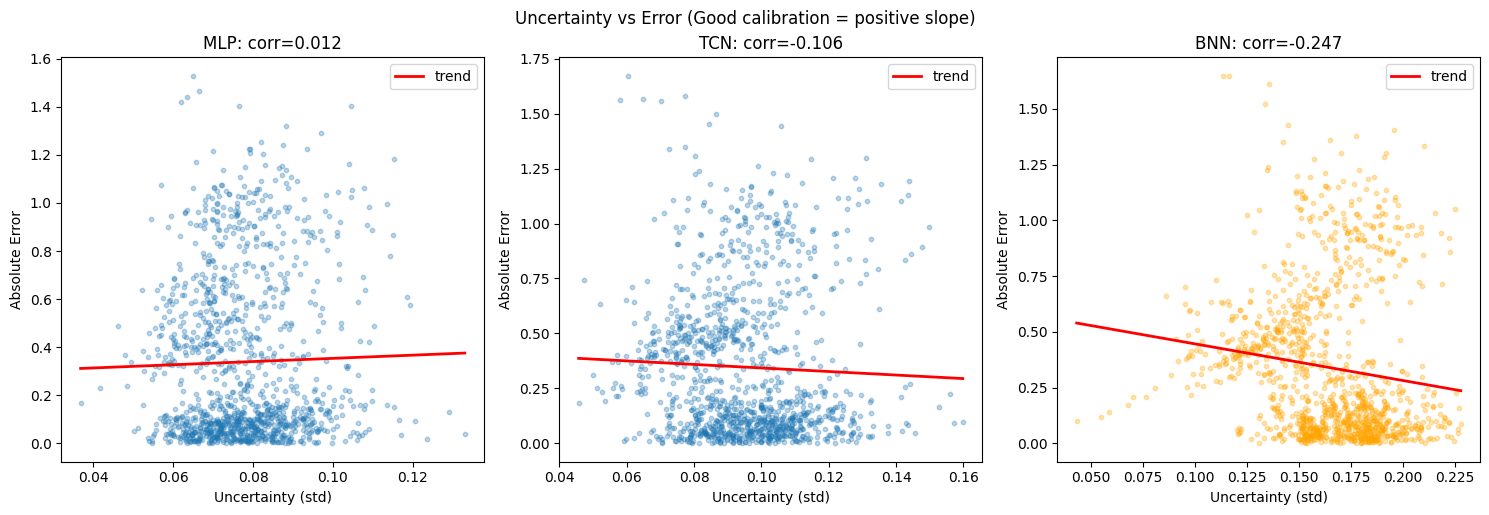

In [ ]:
# Diagnostic: Scatter plot of uncertainty vs error for each model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Compute errors for each model
mlp_errors = np.abs(mlp_results["predictions"] - mlp_results["targets"]).flatten()
mlp_uncert = mlp_results["uncertainties"].flatten()

if tcn_results:
    tcn_errors = np.abs(tcn_results["predictions"] - tcn_results["targets"]).flatten()
    tcn_uncert = tcn_results["uncertainties"].flatten()

if bnn_results:
    bnn_errors = np.abs(bnn_results["predictions"] - bnn_results["targets"]).flatten()
    bnn_uncert = bnn_results["uncertainties"].flatten()

# MLP scatter
axes[0].scatter(mlp_uncert, mlp_errors, alpha=0.3, s=10)
axes[0].set_xlabel("Uncertainty (std)")
axes[0].set_ylabel("Absolute Error")
axes[0].set_title(
    f"MLP: corr={mlp_results['calibration']['error_uncertainty_correlation']:.3f}"
)
# Add trend line
z = np.polyfit(mlp_uncert, mlp_errors, 1)
p = np.poly1d(z)
x_line = np.linspace(mlp_uncert.min(), mlp_uncert.max(), 100)
axes[0].plot(x_line, p(x_line), "r-", linewidth=2, label="trend")
axes[0].legend()

# TCN scatter
if tcn_results:
    axes[1].scatter(tcn_uncert, tcn_errors, alpha=0.3, s=10)
    axes[1].set_xlabel("Uncertainty (std)")
    axes[1].set_ylabel("Absolute Error")
    axes[1].set_title(
        f"TCN: corr={tcn_results['calibration']['error_uncertainty_correlation']:.3f}"
    )
    z = np.polyfit(tcn_uncert, tcn_errors, 1)
    p = np.poly1d(z)
    x_line = np.linspace(tcn_uncert.min(), tcn_uncert.max(), 100)
    axes[1].plot(x_line, p(x_line), "r-", linewidth=2, label="trend")
    axes[1].legend()

# BNN scatter
if bnn_results:
    axes[2].scatter(bnn_uncert, bnn_errors, alpha=0.3, s=10, c="orange")
    axes[2].set_xlabel("Uncertainty (std)")
    axes[2].set_ylabel("Absolute Error")
    axes[2].set_title(
        f"BNN: corr={bnn_results['calibration']['error_uncertainty_correlation']:.3f}"
    )
    z = np.polyfit(bnn_uncert, bnn_errors, 1)
    p = np.poly1d(z)
    x_line = np.linspace(bnn_uncert.min(), bnn_uncert.max(), 100)
    axes[2].plot(x_line, p(x_line), "r-", linewidth=2, label="trend")
    axes[2].legend()

plt.tight_layout()
plt.suptitle("Uncertainty vs Error (Good calibration = positive slope)", y=1.02)
plt.show()

In [ ]:
# Per-dimension calibration analysis for BNN
if bnn_results:
    from scipy import stats

    print("=" * 70)
    print("BNN PER-DIMENSION CALIBRATION ANALYSIS")
    print("=" * 70)
    print(f"{'Dimension':<20} {'Error-Unc Corr':>15} {'Mean Unc':>12} {'Mean Err':>12}")
    print("-" * 70)

    bnn_preds = bnn_results["predictions"]
    bnn_targs = bnn_results["targets"]
    bnn_uncs = bnn_results["uncertainties"]

    dim_calibrations = []
    for i, dim_name in enumerate(SCHWARTZ_VALUE_ORDER):
        dim_errors = np.abs(bnn_preds[:, i] - bnn_targs[:, i])
        dim_uncert = bnn_uncs[:, i]

        corr, _ = stats.spearmanr(dim_uncert, dim_errors)
        mean_unc = dim_uncert.mean()
        mean_err = dim_errors.mean()
        dim_calibrations.append((dim_name, corr, mean_unc, mean_err))

        corr_str = f"{corr:.3f}" if not np.isnan(corr) else "N/A"
        print(f"{dim_name:<20} {corr_str:>15} {mean_unc:>12.4f} {mean_err:>12.4f}")

    print("-" * 70)

    # Count positive vs negative calibration
    pos_cal = sum(1 for _, c, _, _ in dim_calibrations if c > 0)
    neg_cal = sum(1 for _, c, _, _ in dim_calibrations if c < 0)
    print(f"Dimensions with positive calibration: {pos_cal}/10")
    print(f"Dimensions with negative calibration: {neg_cal}/10")
    print("=" * 70)

BNN PER-DIMENSION CALIBRATION ANALYSIS
Dimension             Error-Unc Corr     Mean Unc     Mean Err
----------------------------------------------------------------------
self_direction                -0.109       0.1521       0.4749
stimulation                    0.086       0.1665       0.2078
hedonism                      -0.244       0.1649       0.3452
achievement                   -0.107       0.1664       0.3712
power                         -0.099       0.1663       0.2128
security                      -0.273       0.1645       0.3556
conformity                    -0.173       0.1644       0.3571
tradition                     -0.456       0.1699       0.3743
benevolence                    0.004       0.1526       0.4964
universalism                  -0.310       0.1743       0.2087
----------------------------------------------------------------------
Dimensions with positive calibration: 2/10
Dimensions with negative calibration: 8/10


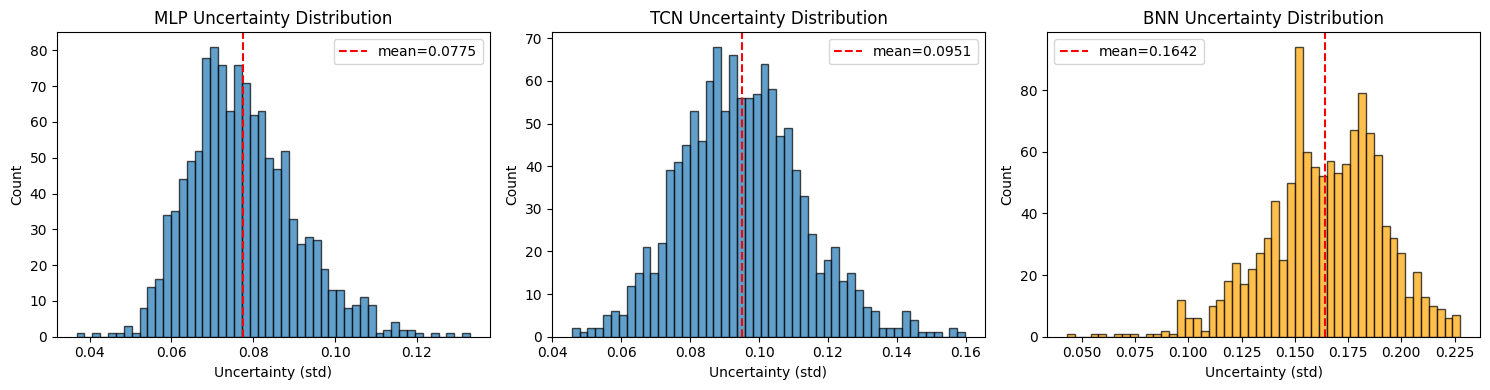


Uncertainty Statistics:
  MLP: min=0.0368, max=0.1330, std=0.0130
  TCN: min=0.0457, max=0.1598, std=0.0176
  BNN: min=0.0430, max=0.2277, std=0.0274


In [ ]:
# Uncertainty distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(mlp_uncert, bins=50, alpha=0.7, edgecolor="black")
axes[0].axvline(
    mlp_uncert.mean(),
    color="red",
    linestyle="--",
    label=f"mean={mlp_uncert.mean():.4f}",
)
axes[0].set_xlabel("Uncertainty (std)")
axes[0].set_ylabel("Count")
axes[0].set_title("MLP Uncertainty Distribution")
axes[0].legend()

if tcn_results:
    axes[1].hist(tcn_uncert, bins=50, alpha=0.7, edgecolor="black")
    axes[1].axvline(
        tcn_uncert.mean(),
        color="red",
        linestyle="--",
        label=f"mean={tcn_uncert.mean():.4f}",
    )
    axes[1].set_xlabel("Uncertainty (std)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("TCN Uncertainty Distribution")
    axes[1].legend()

if bnn_results:
    axes[2].hist(bnn_uncert, bins=50, alpha=0.7, color="orange", edgecolor="black")
    axes[2].axvline(
        bnn_uncert.mean(),
        color="red",
        linestyle="--",
        label=f"mean={bnn_uncert.mean():.4f}",
    )
    axes[2].set_xlabel("Uncertainty (std)")
    axes[2].set_ylabel("Count")
    axes[2].set_title("BNN Uncertainty Distribution")
    axes[2].legend()

plt.tight_layout()
plt.show()

# Print uncertainty statistics
print("\nUncertainty Statistics:")
print(
    f"  MLP: min={mlp_uncert.min():.4f}, max={mlp_uncert.max():.4f}, std={mlp_uncert.std():.4f}"
)
if tcn_results:
    print(
        f"  TCN: min={tcn_uncert.min():.4f}, max={tcn_uncert.max():.4f}, std={tcn_uncert.std():.4f}"
    )
if bnn_results:
    print(
        f"  BNN: min={bnn_uncert.min():.4f}, max={bnn_uncert.max():.4f}, std={bnn_uncert.std():.4f}"
    )

## 9. Conclusions & Next Steps

### Key Findings

**Overfitting:**
- All models show train-val gap indicative of overfitting
- Dataset size (498 train samples) is small for the model capacities (173K-740K params)
- Early stopping helps but doesn't fully resolve the gap

**BNN Calibration Issue:**
- Negative error-uncertainty correlation (-0.348) indicates inverse calibration
- BNN reports 2× higher mean uncertainty than MLP/TCN but in the wrong direction
- Likely causes: KL term dominating, prior-posterior mismatch, or posterior collapse

### Recommended Next Steps

1. **For Overfitting:**
   - Increase regularization (weight decay, dropout)
   - Reduce model capacity (smaller hidden dims)
   - More training data (label additional personas)
   - Data augmentation (embedding noise, temporal jitter)

2. **For BNN Calibration:**
   - Tune KL weight: `loss = mse + beta * kl / batch_size` with beta < 1.0
   - Adjust prior variance (try 0.1 or 0.5 instead of 1.0)
   - Try temperature scaling post-hoc calibration
   - Consider Deep Ensembles instead of BNN (often better calibrated)

3. **For Fair Comparison:**
   - Match parameter counts across models
   - Try TCN with [256, 256] channels to match MLP capacity
   - Run multiple seeds and report mean ± std

In [19]:
# Final summary
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)
print(
    f"Dataset: {len(train_df)} train / {len(val_df)} val / {len(test_df)} test entries"
)
print(
    f"Personas: {train_df.select('persona_id').n_unique()} train / {val_df.select('persona_id').n_unique()} val / {test_df.select('persona_id').n_unique()} test"
)
print(f"Encoder: {text_encoder.model_name}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Random seed: {SEED}")
print()
print(
    f"MLP: {mlp_params:,} params, val_loss={mlp_result['best_val_loss']:.4f}, test_mse={mlp_results['mse_mean']:.4f}, calib={mlp_results['calibration']['error_uncertainty_correlation']:.3f}"
)
if tcn_result and tcn_results:
    print(
        f"TCN: {tcn_params:,} params, val_loss={tcn_result['best_val_loss']:.4f}, test_mse={tcn_results['mse_mean']:.4f}, calib={tcn_results['calibration']['error_uncertainty_correlation']:.3f}"
    )
if bnn_result and bnn_results:
    print(
        f"BNN: {bnn_params:,} params, val_loss={bnn_result['best_val_loss']:.4f}, test_mse={bnn_results['mse_mean']:.4f}, calib={bnn_results['calibration']['error_uncertainty_correlation']:.3f}"
    )
print("=" * 70)


EXPERIMENT SUMMARY
Dataset: 484 train / 126 val / 119 test entries
Personas: 70 train / 15 val / 16 test
Encoder: all-MiniLM-L6-v2
Window size: 3
Random seed: 42

MLP: 370,186 params, val_loss=0.2591, test_mse=0.2322, calib=0.012
TCN: 173,258 params, val_loss=0.2557, test_mse=0.2363, calib=-0.106
BNN: 739,348 params, val_loss=0.2724, test_mse=0.2298, calib=-0.247


In [ ]:
# Check class distribution across all dimensions
import numpy as np

# Get all targets from train set
all_targets = []
for _, targets in train_loader:
    all_targets.append(targets.numpy())
all_targets = np.concatenate(all_targets, axis=0)

print("=" * 60)
print("LABEL DISTRIBUTION ANALYSIS")
print("=" * 60)

# Overall distribution
flat_targets = all_targets.flatten()
unique, counts = np.unique(flat_targets, return_counts=True)
print("\nOverall distribution (all dimensions):")
for val, count in zip(unique, counts):
    pct = count / len(flat_targets) * 100
    print(f"  {val:+.0f}: {count:5d} ({pct:5.1f}%)")

# Per-dimension distribution
print(f"\nPer-dimension distribution:")
print(f"{'Dimension':<20} {'-1':>8} {'0':>8} {'+1':>8} {'Imbalance':>12}")
print("-" * 60)

for i, dim_name in enumerate(SCHWARTZ_VALUE_ORDER):
    dim_targets = all_targets[:, i]
    counts_dict = {-1: 0, 0: 0, 1: 0}
    for val in dim_targets:
        counts_dict[int(val)] = counts_dict.get(int(val), 0) + 1

    total = len(dim_targets)
    max_pct = max(counts_dict.values()) / total * 100
    min_pct = min(counts_dict.values()) / total * 100
    imbalance = max_pct / max(min_pct, 0.1)  # ratio of majority to minority

    print(
        f"{dim_name:<20} {counts_dict[-1]:>8} {counts_dict[0]:>8} {counts_dict[1]:>8} {imbalance:>10.1f}x"
    )

print("=" * 60)

LABEL DISTRIBUTION ANALYSIS

Overall distribution (all dimensions):
  -1:   459 (  9.5%)
  +0:  3369 ( 69.6%)
  +1:  1012 ( 20.9%)

Per-dimension distribution:
Dimension                  -1        0       +1    Imbalance
------------------------------------------------------------
self_direction             83      217      184        2.6x
stimulation                28      382       74       13.6x
hedonism                   58      357       69        6.2x
achievement                35      303      146        8.7x
power                      36      413       35       11.8x
security                   66      333       85        5.0x
conformity                 60      317      107        5.3x
tradition                  34      365       85       10.7x
benevolence                56      250      178        4.5x
universalism                3      432       49      144.0x
